In [1]:
# Design CIS 3D color router
# Resoultion 20 
# RGGB pattern
# Elapsed run time = 33956.9432 s


# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 1/0.675 # 1A = 675nm

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=2.1)
SiO2 = mp.Medium(index=1.4)
HfO2 = mp.Medium(index=1.9)
# SiPD = mp.Medium(epsilon=11.8)

# 해상도 및 사이즈 설정
resolution = 25 # 1 pixel = 27nm
ar_thk = 0.081 * um_scale # AR thickness
fl_size = 0.513 * um_scale # focal layer size
ml_size = 0.216 * um_scale # multi layer size
el_size = 0.027 * um_scale # etch layer size

dti_thk = ar_thk * 2 # DTI thickness 
sp_size = 0.621 * um_scale # subpixel size
# sp_size = 2 * um_scale # SiPD size

Lpml = 0.5 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 0.5

# 설계 공간
design_region_width_x = sp_size * 2 # 디자인 영역 x
design_region_width_y = sp_size * 2 # 디자인 영역 y
design_region_height = ml_size * 5 + el_size * 4 # 디자인 영역 높이 z

# 전체 공간
Sx = design_region_width_x
Sy = design_region_width_y
Sz = Lpml + ar_thk + fl_size + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)

# 파장, 주파수 설정
wavelengths = np.linspace(0.40*um_scale, 0.70*um_scale, 31) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# Fabrication Constraints 설정

minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)


# source 설정
width = 0.4

fcen_red = 1/(0.65*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.55*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.45*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height))

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, SiN, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

# 대각선대칭

def mapping(x, eta, beta):
    x_copy = (x.reshape(Nx * Ny, Nz)).transpose()

    # projection
    z = 0
    x2 = []

    while z < Nz:
        
        number = z
        x1 = x_copy[int(number)]
        
        # filter
        filtered_field = mpa.conic_filter(
            x1,
            filter_radius,
            design_region_width_x,
            design_region_width_y,
            design_region_resolution,
        )
        
        z_slice = ((filtered_field.reshape(Nx, Ny)) + filtered_field.reshape(Nx, Ny).transpose()) / 2
        z_slice = mpa.tanh_projection(z_slice, beta, eta).flatten()
        x2 = npa.concatenate((x2,z_slice.flatten()),axis=0) 
        z = z + 1

    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    x = x2

    return x


# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),

    # Focal Layer
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size/2), size=mp.Vector3(Sx, Sy, fl_size), material=SiO2
    ),

    #AR coating
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size - ar_thk/2 - Lpml/2), size=mp.Vector3(Sx, Sy, ar_thk + Lpml), material=HfO2
    ),

    # # DTI가 있을 경우 사용
    # mp.Block(
    #     center=mp.Vector3(Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # )
]

# Meep simulation 세팅

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]


fred = []
fgreen = []
fblue = []
# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[21:30,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[21:30,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_0_y[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_y[11:20,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[1:10,1]) ** 2) + npa.sum(npa.abs(fields_3_y[1:10,1]) ** 2)
    redfactor = 6.4
    greenfactor = 4.8
    bluefactor = 2.9
    
    fred.append(red/redfactor)
    fgreen.append(green/greenfactor)
    fblue.append(blue/bluefactor)
    return blue/bluefactor + green/greenfactor + red/redfactor

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)


In [2]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609636 s
-----------
on time step 1031 (time=20.62), 0.00388068 s/step
run 0 finished at t = 24.62 (1231 timesteps)
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)
/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


on time step 282 (time=5.64), 0.0141973 s/step
on time step 579 (time=11.58), 0.0134779 s/step
on time step 888 (time=17.76), 0.0129831 s/step
on time step 1216 (time=24.32), 0.0122513 s/step
on time step 1541 (time=30.82), 0.0123209 s/step
on time step 1839 (time=36.78), 0.0134267 s/step
on time step 2133 (time=42.66), 0.0136078 s/step
on time step 2429 (time=48.58), 0.0135208 s/step
on time step 2724 (time=54.48), 0.0135683 s/step
on time step 3019 (time=60.38), 0.0135843 s/step
on time step 3321 (time=66.42), 0.0132744 s/step
on time step 3813 (time=76.26), 0.00815303 s/step
on time step 5166 (time=103.32), 0.00295723 s/step
on time step 6519 (time=130.38), 0.00295694 s/step
on time step 7872 (time=157.44), 0.00295949 s/step
run 1 finished at t = 181.26 (9063 timesteps)
Calculating gradient...


In [3]:
print(dJ_du)

[[ 1.96922981e-05  1.93912594e-05 -1.20313011e-04 ...  5.33787169e-05
   3.63230735e-05  8.80234091e-07]
 [-6.31712696e-07  5.77959509e-05 -1.42248803e-04 ...  4.95884289e-05
   3.38056748e-05  7.00897840e-07]
 [-9.48033014e-06  5.89745431e-05 -1.53884549e-04 ...  4.78213074e-05
   3.28118952e-05  6.21904101e-07]
 ...
 [ 8.53003484e-06  1.04548187e-04  1.28135434e-04 ... -4.59383518e-05
  -3.81262990e-05  5.23036087e-08]
 [-4.10274780e-06  1.08390350e-04  5.52145835e-05 ... -4.48181944e-05
  -3.77688583e-05  3.73309277e-08]
 [-1.09442437e-05  6.34450057e-05  7.39185702e-07 ... -3.19602082e-05
  -2.64944197e-05  2.01351645e-08]]


In [4]:
dJ_du_sum = np.sum(dJ_du[:], axis=1)


In [5]:
print(dJ_du_sum)

[-0.00250979 -0.00223085 -0.00212017 ... -0.00039834 -0.00098224
 -0.00152514]


In [6]:
db = 1e-3
choose = 100
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614019 s
-----------


run 2 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614906 s
-----------


run 3 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.63478 s
-----------


run 4 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602287 s
-----------


run 5 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617865 s
-----------


run 6 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620921 s
-----------


run 7 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61423 s
-----------


run 8 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59964 s
-----------


run 9 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607188 s
-----------


run 10 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596284 s
-----------


run 11 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60623 s
-----------


run 12 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601267 s
-----------


run 13 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607063 s
-----------


run 14 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601836 s
-----------


run 15 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610981 s
-----------


run 16 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607397 s
-----------


run 17 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599266 s
-----------


run 18 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611888 s
-----------


run 19 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595778 s
-----------


run 20 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.629183 s
-----------


run 21 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604386 s
-----------


run 22 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606341 s
-----------


run 23 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602354 s
-----------


run 24 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614298 s
-----------


run 25 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600507 s
-----------


run 26 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608704 s
-----------


run 27 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602137 s
-----------


run 28 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602872 s
-----------


run 29 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606462 s
-----------


run 30 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601398 s
-----------


run 31 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608324 s
-----------


run 32 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608831 s
-----------


run 33 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597835 s
-----------


run 34 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608789 s
-----------


run 35 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600252 s
-----------


run 36 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615457 s
-----------


run 37 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606199 s
-----------


run 38 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599205 s
-----------


run 39 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606545 s
-----------


run 40 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599743 s
-----------


run 41 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604017 s
-----------


run 42 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622824 s
-----------


run 43 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604648 s
-----------


run 44 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608883 s
-----------


run 45 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596559 s
-----------


run 46 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608839 s
-----------


run 47 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606992 s
-----------


run 48 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598304 s
-----------


run 49 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603699 s
-----------


run 50 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.5991 s
-----------


run 51 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60827 s
-----------


run 52 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603488 s
-----------


run 53 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599431 s
-----------


run 54 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607261 s
-----------


run 55 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594678 s
-----------


run 56 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609347 s
-----------


run 57 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604023 s
-----------


run 58 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.631386 s
-----------


run 59 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602395 s
-----------


run 60 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594751 s
-----------


run 61 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61034 s
-----------


run 62 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601617 s
-----------


run 63 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6095 s
-----------


run 64 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602282 s
-----------


run 65 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596556 s
-----------


run 66 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60895 s
-----------


run 67 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.5984 s
-----------


run 68 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609972 s
-----------


run 69 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603194 s
-----------


run 70 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599325 s
-----------


run 71 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604672 s
-----------


run 72 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597573 s
-----------


run 73 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.628577 s
-----------


run 74 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612429 s
-----------


run 75 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60213 s
-----------


run 76 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611187 s
-----------


run 77 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600657 s
-----------


run 78 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606924 s
-----------


run 79 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612835 s
-----------


run 80 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603119 s
-----------


run 81 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609946 s
-----------


run 82 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.5973 s
-----------


run 83 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604586 s
-----------


run 84 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607594 s
-----------


run 85 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596926 s
-----------


run 86 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605493 s
-----------


run 87 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602982 s
-----------


run 88 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598956 s
-----------


run 89 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612434 s
-----------


run 90 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59418 s
-----------


run 91 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.626585 s
-----------


run 92 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597329 s
-----------


run 93 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612084 s
-----------


run 94 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60639 s
-----------


run 95 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60048 s
-----------


run 96 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606023 s
-----------


run 97 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595677 s
-----------


run 98 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609465 s
-----------


run 99 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.633802 s
-----------


run 100 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615631 s
-----------


run 101 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605192 s
-----------


run 102 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601278 s
-----------


run 103 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.626013 s
-----------


run 104 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607141 s
-----------


run 105 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595806 s
-----------


run 106 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603946 s
-----------


run 107 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601208 s
-----------


run 108 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604523 s
-----------


run 109 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609278 s
-----------


run 110 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596726 s
-----------


run 111 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607446 s
-----------


run 112 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60104 s
-----------


run 113 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610948 s
-----------


run 114 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603579 s
-----------


run 115 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607882 s
-----------


run 116 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607445 s
-----------


run 117 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595503 s
-----------


run 118 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608944 s
-----------


run 119 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.626492 s
-----------


run 120 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598969 s
-----------


run 121 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60594 s
-----------


run 122 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598969 s
-----------


run 123 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610944 s
-----------


run 124 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601788 s
-----------


run 125 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606806 s
-----------


run 126 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609236 s
-----------


run 127 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600168 s
-----------


run 128 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605721 s
-----------


run 129 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601438 s
-----------


run 130 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603797 s
-----------


run 131 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6337 s
-----------


run 132 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595865 s
-----------


run 133 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611589 s
-----------


run 134 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601219 s
-----------


run 135 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60431 s
-----------


run 136 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609396 s
-----------


run 137 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60141 s
-----------


run 138 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6088 s
-----------


run 139 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594144 s
-----------


run 140 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608286 s
-----------


run 141 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608806 s
-----------


run 142 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601848 s
-----------


run 143 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.628251 s
-----------


run 144 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59496 s
-----------


run 145 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634292 s
-----------


run 146 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609465 s
-----------


run 147 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598663 s
-----------


run 148 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60534 s
-----------


run 149 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598198 s
-----------


run 150 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610265 s
-----------


run 151 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602618 s
-----------


run 152 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606493 s
-----------


run 153 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614572 s
-----------


run 154 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599054 s
-----------


run 155 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608669 s
-----------


run 156 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600391 s
-----------


run 157 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606466 s
-----------


run 158 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605735 s
-----------


run 159 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622303 s
-----------


run 160 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609073 s
-----------


run 161 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599349 s
-----------


run 162 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609285 s
-----------


run 163 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610972 s
-----------


run 164 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606997 s
-----------


run 165 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620181 s
-----------


run 166 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600737 s
-----------


run 167 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601391 s
-----------


run 168 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621175 s
-----------


run 169 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621703 s
-----------


run 170 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612688 s
-----------


run 171 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606436 s
-----------


run 172 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61902 s
-----------


run 173 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618151 s
-----------


run 174 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612772 s
-----------


run 175 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.629993 s
-----------


run 176 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616099 s
-----------


run 177 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.628463 s
-----------


run 178 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610906 s
-----------


run 179 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618713 s
-----------


run 180 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604559 s
-----------


run 181 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617715 s
-----------


run 182 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.633084 s
-----------


run 183 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616681 s
-----------


run 184 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.640515 s
-----------


run 185 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634684 s
-----------


run 186 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618347 s
-----------


run 187 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614319 s
-----------


run 188 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608617 s
-----------


run 189 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595688 s
-----------


run 190 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604885 s
-----------


run 191 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622906 s
-----------


run 192 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6173 s
-----------


run 193 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604774 s
-----------


run 194 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606554 s
-----------


run 195 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621066 s
-----------


run 196 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617847 s
-----------


run 197 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618099 s
-----------


run 198 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622069 s
-----------


run 199 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.642266 s
-----------


run 200 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614763 s
-----------
run 201 finished at t = 24.2 (1210 timesteps)


In [7]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

In [8]:
print(dJ_du_sum)

[-0.00250979 -0.00223085 -0.00212017 ... -0.00039834 -0.00098224
 -0.00152514]


In [9]:
print(g_discrete)

[[0.0015579661289955027], [-0.0008086017135866541], [-0.0006987589928897364], [-0.00044593147618954276], [-0.0007959797545531444], [0.0007551043847975336], [0.0001833580345333985], [-3.1237948228124424e-05], [0.0014965749111084392], [-0.00020221267726938663], [0.0007443595064771102], [0.0014701907575798145], [-0.00037440955491518935], [0.0011973849223245736], [-0.002797493393824624], [0.0007311267999909887], [0.0005637993072404868], [0.0015493212752737406], [-0.0022763215259402614], [0.00035952772403646804], [-0.0016055650808866062], [0.0016260651873878373], [0.00022085149620210132], [0.00036919874446539325], [0.00030878442114357085], [0.0014460713027020233], [-0.0009912478597939867], [0.0006286897464846675], [-0.00014869834430442097], [0.001589323201045545], [0.0018991985366589859], [-3.831362027639784e-05], [-0.0005923660282292076], [-0.00015812164910755655], [0.00042181304849009393], [0.000992673988342574], [0.0012537993070438347], [-0.0005279176278349951], [-0.002447415024420252], 

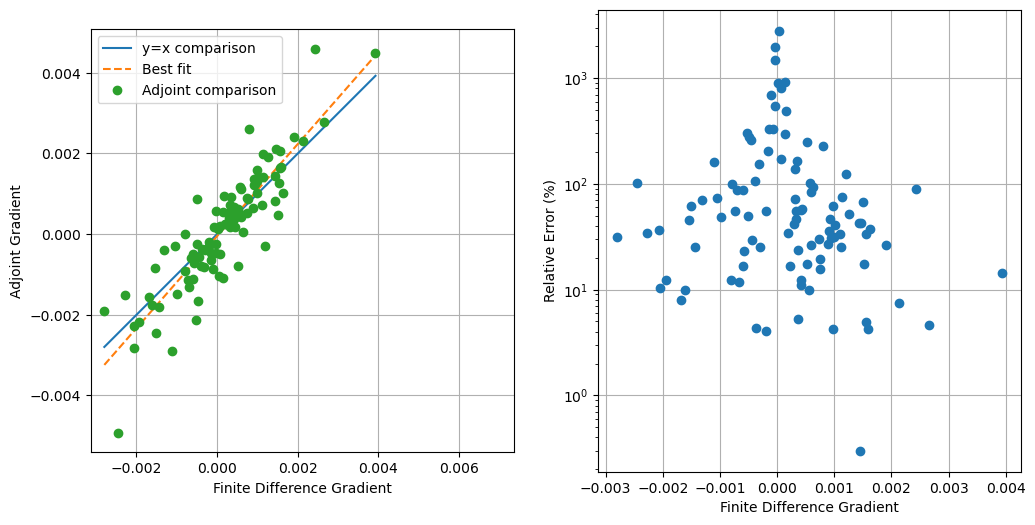

In [10]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()


In [11]:
db = 1e-2
choose = 100
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613203 s
-----------


run 202 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619367 s
-----------


run 203 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609995 s
-----------


run 204 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600017 s
-----------


run 205 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605328 s
-----------


run 206 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611893 s
-----------


run 207 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619232 s
-----------


run 208 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607494 s
-----------


run 209 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616299 s
-----------


run 210 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610971 s
-----------


run 211 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.638301 s
-----------


run 212 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617407 s
-----------


run 213 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608771 s
-----------


run 214 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618098 s
-----------


run 215 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615363 s
-----------


run 216 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606189 s
-----------


run 217 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613843 s
-----------


run 218 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601148 s
-----------


run 219 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610891 s
-----------


run 220 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606039 s
-----------


run 221 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608901 s
-----------


run 222 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60705 s
-----------


run 223 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621183 s
-----------


run 224 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620521 s
-----------


run 225 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595773 s
-----------


run 226 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592181 s
-----------


run 227 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589297 s
-----------


run 228 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590244 s
-----------


run 229 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594574 s
-----------


run 230 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595203 s
-----------


run 231 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592296 s
-----------


run 232 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596322 s
-----------


run 233 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595933 s
-----------


run 234 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594137 s
-----------


run 235 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592319 s
-----------


run 236 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596317 s
-----------


run 237 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593934 s
-----------


run 238 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591808 s
-----------


run 239 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590599 s
-----------


run 240 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595945 s
-----------


run 241 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597908 s
-----------


run 242 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596927 s
-----------


run 243 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623198 s
-----------


run 244 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597703 s
-----------


run 245 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596925 s
-----------


run 246 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606775 s
-----------


run 247 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600132 s
-----------


run 248 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603104 s
-----------


run 249 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601022 s
-----------


run 250 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600771 s
-----------


run 251 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587908 s
-----------


run 252 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590162 s
-----------


run 253 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599155 s
-----------


run 254 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622584 s
-----------


run 255 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602502 s
-----------


run 256 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602221 s
-----------


run 257 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60506 s
-----------


run 258 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603676 s
-----------


run 259 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601683 s
-----------


run 260 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601007 s
-----------


run 261 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603369 s
-----------


run 262 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598456 s
-----------


run 263 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610846 s
-----------


run 264 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603484 s
-----------


run 265 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.91142e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604337 s
-----------


run 266 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601711 s
-----------


run 267 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598338 s
-----------


run 268 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598937 s
-----------


run 269 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604676 s
-----------


run 270 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608875 s
-----------


run 271 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601638 s
-----------


run 272 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610557 s
-----------


run 273 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606349 s
-----------


run 274 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600087 s
-----------


run 275 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622457 s
-----------


run 276 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599229 s
-----------


run 277 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60072 s
-----------


run 278 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599105 s
-----------


run 279 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602481 s
-----------


run 280 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605924 s
-----------


run 281 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603811 s
-----------


run 282 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601918 s
-----------


run 283 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602198 s
-----------


run 284 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607738 s
-----------


run 285 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600186 s
-----------


run 286 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600268 s
-----------


run 287 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606775 s
-----------


run 288 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595974 s
-----------


run 289 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588838 s
-----------


run 290 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588645 s
-----------


run 291 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588717 s
-----------


run 292 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588046 s
-----------


run 293 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59144 s
-----------


run 294 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590221 s
-----------


run 295 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595413 s
-----------


run 296 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594568 s
-----------


run 297 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597636 s
-----------


run 298 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590619 s
-----------


run 299 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593002 s
-----------


run 300 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596378 s
-----------


run 301 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590286 s
-----------


run 302 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595325 s
-----------


run 303 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589689 s
-----------


run 304 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594585 s
-----------


run 305 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593523 s
-----------


run 306 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597374 s
-----------


run 307 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589026 s
-----------


run 308 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591775 s
-----------


run 309 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592575 s
-----------


run 310 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594816 s
-----------


run 311 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591267 s
-----------


run 312 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593526 s
-----------


run 313 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591505 s
-----------


run 314 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589623 s
-----------


run 315 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59297 s
-----------


run 316 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601302 s
-----------


run 317 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596218 s
-----------


run 318 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592993 s
-----------


run 319 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595084 s
-----------


run 320 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590887 s
-----------


run 321 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595989 s
-----------


run 322 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600092 s
-----------


run 323 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595891 s
-----------


run 324 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590058 s
-----------


run 325 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594039 s
-----------


run 326 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590072 s
-----------


run 327 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.69685e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619048 s
-----------


run 328 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594485 s
-----------


run 329 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594983 s
-----------


run 330 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599166 s
-----------


run 331 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59261 s
-----------


run 332 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596857 s
-----------


run 333 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589169 s
-----------


run 334 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601922 s
-----------


run 335 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595294 s
-----------


run 336 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59441 s
-----------


run 337 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590795 s
-----------


run 338 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588126 s
-----------


run 339 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597609 s
-----------


run 340 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617393 s
-----------


run 341 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593062 s
-----------


run 342 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593612 s
-----------


run 343 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588143 s
-----------


run 344 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598018 s
-----------


run 345 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59365 s
-----------


run 346 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593714 s
-----------


run 347 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59598 s
-----------


run 348 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589311 s
-----------


run 349 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595255 s
-----------


run 350 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593678 s
-----------


run 351 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595251 s
-----------


run 352 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592212 s
-----------


run 353 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617889 s
-----------


run 354 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597161 s
-----------


run 355 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596117 s
-----------


run 356 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596473 s
-----------


run 357 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621746 s
-----------


run 358 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594684 s
-----------


run 359 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594819 s
-----------


run 360 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593271 s
-----------


run 361 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59952 s
-----------


run 362 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587043 s
-----------


run 363 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590894 s
-----------


run 364 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595349 s
-----------


run 365 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619002 s
-----------


run 366 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.5956 s
-----------


run 367 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597725 s
-----------


run 368 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592876 s
-----------


run 369 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594821 s
-----------


run 370 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617941 s
-----------


run 371 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623747 s
-----------


run 372 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60515 s
-----------


run 373 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590002 s
-----------


run 374 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.98023e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617675 s
-----------


run 375 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609749 s
-----------


run 376 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590845 s
-----------


run 377 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596534 s
-----------


run 378 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587858 s
-----------


run 379 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594414 s
-----------


run 380 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592352 s
-----------


run 381 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591088 s
-----------


run 382 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590993 s
-----------


run 383 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590368 s
-----------


run 384 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59042 s
-----------


run 385 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.58938 s
-----------


run 386 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593386 s
-----------


run 387 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59251 s
-----------


run 388 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606131 s
-----------


run 389 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594962 s
-----------


run 390 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611745 s
-----------


run 391 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600152 s
-----------


run 392 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595007 s
-----------


run 393 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591125 s
-----------


run 394 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59483 s
-----------


run 395 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595903 s
-----------


run 396 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59534 s
-----------


run 397 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598892 s
-----------


run 398 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591297 s
-----------


run 399 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597831 s
-----------


run 400 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589145 s
-----------
run 401 finished at t = 24.2 (1210 timesteps)


In [12]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

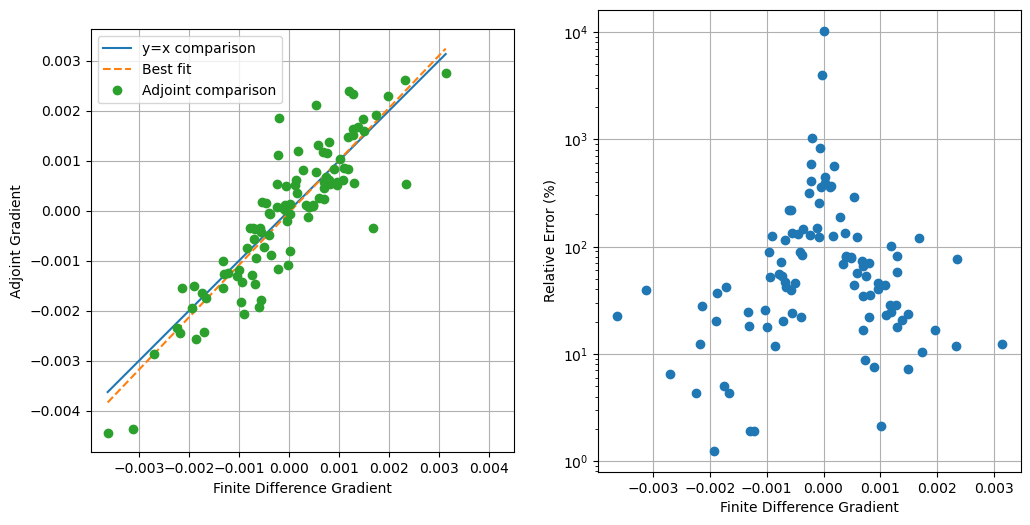

In [13]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()


In [14]:
db = 1e-1
choose = 100
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603847 s
-----------


run 402 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617824 s
-----------


run 403 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606848 s
-----------


run 404 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.91006e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600884 s
-----------


run 405 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59933 s
-----------


run 406 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603473 s
-----------


run 407 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615357 s
-----------


run 408 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608028 s
-----------


run 409 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605965 s
-----------


run 410 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596952 s
-----------


run 411 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598079 s
-----------


run 412 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609058 s
-----------


run 413 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591976 s
-----------


run 414 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60198 s
-----------


run 415 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598388 s
-----------


run 416 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622675 s
-----------


run 417 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603829 s
-----------


run 418 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621879 s
-----------


run 419 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602381 s
-----------


run 420 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.635731 s
-----------


run 421 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606412 s
-----------


run 422 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597841 s
-----------


run 423 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597383 s
-----------


run 424 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598009 s
-----------


run 425 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611057 s
-----------


run 426 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604044 s
-----------


run 427 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604187 s
-----------


run 428 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593219 s
-----------


run 429 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588648 s
-----------


run 430 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591468 s
-----------


run 431 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587793 s
-----------


run 432 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.09808e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59201 s
-----------


run 433 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.591683 s
-----------


run 434 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588078 s
-----------


run 435 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589324 s
-----------


run 436 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596398 s
-----------


run 437 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592881 s
-----------


run 438 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604809 s
-----------


run 439 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590245 s
-----------


run 440 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.5908 s
-----------


run 441 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59071 s
-----------


run 442 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594955 s
-----------


run 443 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596252 s
-----------


run 444 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593332 s
-----------


run 445 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587621 s
-----------


run 446 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608188 s
-----------


run 447 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608292 s
-----------


run 448 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609025 s
-----------


run 449 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60055 s
-----------


run 450 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588849 s
-----------


run 451 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612086 s
-----------


run 452 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588792 s
-----------


run 453 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592069 s
-----------


run 454 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589253 s
-----------


run 455 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590776 s
-----------


run 456 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606103 s
-----------


run 457 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615186 s
-----------


run 458 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602509 s
-----------


run 459 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607752 s
-----------


run 460 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606852 s
-----------
run 461 finished at t = 24.2 (1210 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60874 s
-----------


run 462 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.630518 s
-----------


run 463 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613628 s
-----------


run 464 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617733 s
-----------


run 465 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61288 s
-----------


run 466 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608594 s
-----------


run 467 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604586 s
-----------


run 468 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613151 s
-----------


run 469 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596232 s
-----------


run 470 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621459 s
-----------


run 471 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.624033 s
-----------


run 472 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599386 s
-----------


run 473 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588522 s
-----------


run 474 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.58859 s
-----------


run 475 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595758 s
-----------


run 476 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603633 s
-----------


run 477 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610083 s
-----------


run 478 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600018 s
-----------


run 479 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622445 s
-----------


run 480 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597008 s
-----------


run 481 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.63125 s
-----------


run 482 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607736 s
-----------


run 483 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61034 s
-----------


run 484 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.637883 s
-----------


run 485 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606947 s
-----------


run 486 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604393 s
-----------


run 487 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597893 s
-----------


run 488 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594092 s
-----------


run 489 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600016 s
-----------


run 490 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607173 s
-----------


run 491 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600163 s
-----------


run 492 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593361 s
-----------


run 493 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596572 s
-----------


run 494 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608404 s
-----------


run 495 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595613 s
-----------


run 496 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61411 s
-----------


run 497 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607795 s
-----------


run 498 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598279 s
-----------


run 499 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597946 s
-----------


run 500 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606069 s
-----------


run 501 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599555 s
-----------


run 502 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605962 s
-----------


run 503 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604785 s
-----------


run 504 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.627557 s
-----------


run 505 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60577 s
-----------


run 506 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599324 s
-----------


run 507 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596904 s
-----------


run 508 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599385 s
-----------


run 509 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595156 s
-----------


run 510 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609991 s
-----------


run 511 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605773 s
-----------


run 512 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598208 s
-----------


run 513 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59722 s
-----------


run 514 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613521 s
-----------


run 515 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596697 s
-----------


run 516 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595749 s
-----------


run 517 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614403 s
-----------


run 518 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593751 s
-----------


run 519 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596981 s
-----------


run 520 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618557 s
-----------


run 521 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.62866 s
-----------


run 522 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60309 s
-----------


run 523 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61253 s
-----------


run 524 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.587592 s
-----------


run 525 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619326 s
-----------


run 526 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596889 s
-----------


run 527 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634592 s
-----------


run 528 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.592379 s
-----------


run 529 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601015 s
-----------


run 530 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604716 s
-----------


run 531 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623515 s
-----------


run 532 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598054 s
-----------


run 533 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604056 s
-----------


run 534 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618605 s
-----------


run 535 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609168 s
-----------


run 536 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615935 s
-----------


run 537 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6134 s
-----------


run 538 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596964 s
-----------


run 539 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606261 s
-----------


run 540 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611738 s
-----------


run 541 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600459 s
-----------


run 542 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598154 s
-----------


run 543 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.593517 s
-----------


run 544 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597461 s
-----------


run 545 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594397 s
-----------


run 546 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.62089 s
-----------


run 547 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.596269 s
-----------


run 548 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605635 s
-----------


run 549 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.597893 s
-----------


run 550 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611984 s
-----------


run 551 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614468 s
-----------


run 552 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595283 s
-----------


run 553 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595 s
-----------


run 554 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620082 s
-----------


run 555 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618649 s
-----------


run 556 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595108 s
-----------


run 557 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.588537 s
-----------


run 558 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60684 s
-----------


run 559 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608342 s
-----------


run 560 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600091 s
-----------


run 561 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613019 s
-----------


run 562 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.607021 s
-----------


run 563 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605791 s
-----------


run 564 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615246 s
-----------


run 565 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616977 s
-----------


run 566 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594674 s
-----------


run 567 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605502 s
-----------


run 568 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609813 s
-----------


run 569 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606279 s
-----------


run 570 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600713 s
-----------


run 571 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620096 s
-----------


run 572 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.59793 s
-----------


run 573 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600783 s
-----------


run 574 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623486 s
-----------


run 575 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619497 s
-----------


run 576 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.625383 s
-----------


run 577 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.590948 s
-----------


run 578 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602135 s
-----------


run 579 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595813 s
-----------


run 580 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60365 s
-----------


run 581 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609322 s
-----------


run 582 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611978 s
-----------


run 583 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594569 s
-----------


run 584 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604278 s
-----------


run 585 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599602 s
-----------


run 586 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616686 s
-----------


run 587 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601158 s
-----------


run 588 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599259 s
-----------


run 589 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620247 s
-----------


run 590 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605085 s
-----------


run 591 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594457 s
-----------


run 592 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61583 s
-----------


run 593 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603676 s
-----------


run 594 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.589159 s
-----------


run 595 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.19345e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.595917 s
-----------


run 596 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.594946 s
-----------


run 597 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620584 s
-----------


run 598 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.63346 s
-----------


run 599 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622876 s
-----------


run 600 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611006 s
-----------
run 601 finished at t = 24.2 (1210 timesteps)


In [15]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

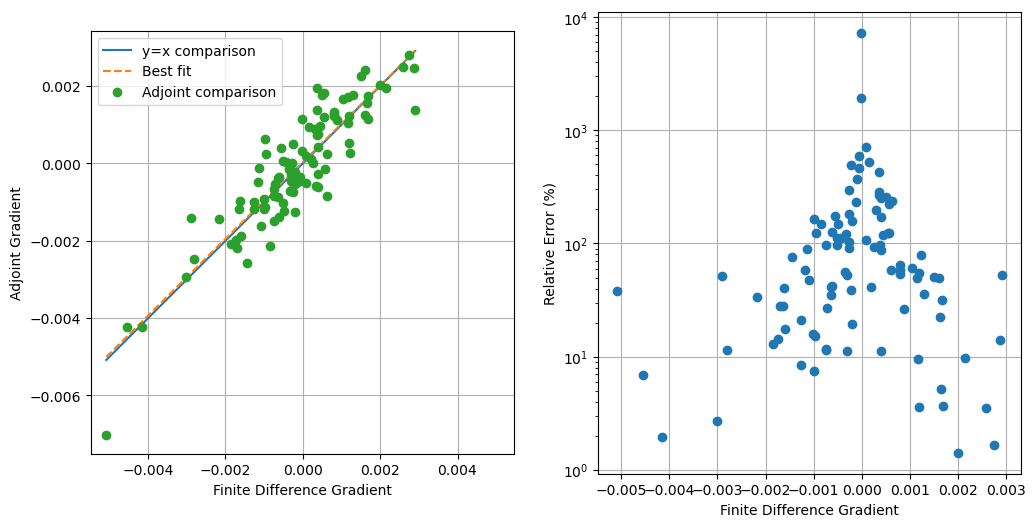

In [16]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()


In [20]:
db = 0.19
choose = 100
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616531 s
-----------


run 602 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617182 s
-----------


run 603 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618694 s
-----------


run 604 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620837 s
-----------


run 605 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620168 s
-----------


run 606 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618322 s
-----------


run 607 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60902 s
-----------


run 608 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614048 s
-----------


run 609 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.629371 s
-----------


run 610 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620404 s
-----------


run 611 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619896 s
-----------


run 612 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623981 s
-----------


run 613 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.88486e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615286 s
-----------


run 614 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614757 s
-----------


run 615 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61727 s
-----------


run 616 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617207 s
-----------


run 617 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616066 s
-----------


run 618 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611568 s
-----------


run 619 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621922 s
-----------


run 620 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.626779 s
-----------


run 621 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61476 s
-----------


run 622 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61942 s
-----------


run 623 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612009 s
-----------


run 624 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617204 s
-----------


run 625 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61072 s
-----------


run 626 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614048 s
-----------


run 627 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620477 s
-----------


run 628 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.628288 s
-----------


run 629 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.635615 s
-----------


run 630 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620336 s
-----------


run 631 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.00407e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601653 s
-----------


run 632 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.637083 s
-----------


run 633 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617203 s
-----------


run 634 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605852 s
-----------


run 635 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.625549 s
-----------


run 636 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.625301 s
-----------


run 637 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.631379 s
-----------


run 638 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.63592 s
-----------


run 639 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.640513 s
-----------


run 640 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.638262 s
-----------


run 641 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.647866 s
-----------


run 642 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618328 s
-----------


run 643 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614274 s
-----------


run 644 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618982 s
-----------


run 645 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623464 s
-----------


run 646 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623411 s
-----------


run 647 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623342 s
-----------


run 648 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61784 s
-----------


run 649 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615429 s
-----------


run 650 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612696 s
-----------


run 651 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609502 s
-----------


run 652 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608865 s
-----------


run 653 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619881 s
-----------


run 654 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621159 s
-----------


run 655 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.623194 s
-----------


run 656 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.627642 s
-----------


run 657 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619397 s
-----------


run 658 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614836 s
-----------


run 659 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.639075 s
-----------


run 660 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634054 s
-----------


run 661 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611444 s
-----------


run 662 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618822 s
-----------


run 663 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618143 s
-----------


run 664 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 4.79221e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619801 s
-----------


run 665 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.62074 s
-----------


run 666 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.640931 s
-----------


run 667 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.638878 s
-----------


run 668 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.641993 s
-----------


run 669 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611413 s
-----------


run 670 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.624223 s
-----------


run 671 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606018 s
-----------


run 672 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612115 s
-----------


run 673 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616764 s
-----------


run 674 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612333 s
-----------


run 675 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616749 s
-----------


run 676 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621384 s
-----------


run 677 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619583 s
-----------


run 678 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621199 s
-----------


run 679 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.62089 s
-----------


run 680 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619776 s
-----------


run 681 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616018 s
-----------


run 682 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617802 s
-----------


run 683 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634675 s
-----------


run 684 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.648076 s
-----------


run 685 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617374 s
-----------


run 686 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.626061 s
-----------


run 687 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617895 s
-----------


run 688 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.640352 s
-----------


run 689 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620408 s
-----------


run 690 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.636528 s
-----------


run 691 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.641631 s
-----------


run 692 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608952 s
-----------


run 693 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619329 s
-----------


run 694 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.625371 s
-----------


run 695 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614595 s
-----------


run 696 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615658 s
-----------


run 697 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614073 s
-----------


run 698 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622353 s
-----------


run 699 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622702 s
-----------


run 700 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60585 s
-----------


run 701 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621419 s
-----------


run 702 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611416 s
-----------


run 703 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.60978 s
-----------


run 704 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620228 s
-----------


run 705 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616321 s
-----------


run 706 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620556 s
-----------


run 707 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610213 s
-----------


run 708 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618157 s
-----------


run 709 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61589 s
-----------


run 710 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.608266 s
-----------


run 711 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61397 s
-----------


run 712 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613844 s
-----------


run 713 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.634668 s
-----------


run 714 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606084 s
-----------


run 715 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611929 s
-----------


run 716 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614552 s
-----------


run 717 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.636876 s
-----------


run 718 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.628235 s
-----------


run 719 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614684 s
-----------


run 720 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616422 s
-----------


run 721 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.625366 s
-----------


run 722 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.644484 s
-----------


run 723 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.638835 s
-----------


run 724 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611092 s
-----------


run 725 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612277 s
-----------


run 726 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615972 s
-----------


run 727 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.645331 s
-----------


run 728 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.644844 s
-----------


run 729 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.624253 s
-----------


run 730 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.81334e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.616803 s
-----------


run 731 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.60012e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615238 s
-----------


run 732 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.620653 s
-----------


run 733 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615114 s
-----------


run 734 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.622122 s
-----------


run 735 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.48091e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.62003 s
-----------


run 736 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621666 s
-----------


run 737 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.624899 s
-----------


run 738 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.7895e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618152 s
-----------


run 739 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621853 s
-----------


run 740 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.90871e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611287 s
-----------


run 741 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612092 s
-----------


run 742 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613194 s
-----------


run 743 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61137 s
-----------


run 744 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610277 s
-----------


run 745 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611297 s
-----------


run 746 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.632375 s
-----------


run 747 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614927 s
-----------


run 748 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.61968 s
-----------


run 749 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617069 s
-----------


run 750 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618967 s
-----------


run 751 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617855 s
-----------


run 752 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613438 s
-----------


run 753 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.47955e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.636044 s
-----------


run 754 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603415 s
-----------


run 755 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614393 s
-----------


run 756 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610524 s
-----------


run 757 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.598547 s
-----------


run 758 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612581 s
-----------


run 759 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.621437 s
-----------


run 760 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618852 s
-----------


run 761 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619466 s
-----------


run 762 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.606966 s
-----------


run 763 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.617871 s
-----------


run 764 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602282 s
-----------


run 765 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619313 s
-----------


run 766 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605739 s
-----------


run 767 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609322 s
-----------


run 768 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.610337 s
-----------


run 769 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612309 s
-----------


run 770 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.639683 s
-----------


run 771 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.19481e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614347 s
-----------


run 772 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613569 s
-----------


run 773 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614317 s
-----------


run 774 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612548 s
-----------


run 775 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.612651 s
-----------


run 776 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.602058 s
-----------


run 777 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.605155 s
-----------


run 778 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.28882e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.627519 s
-----------


run 779 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600577 s
-----------


run 780 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603122 s
-----------


run 781 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.603455 s
-----------


run 782 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.6226e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.599936 s
-----------


run 783 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.618004 s
-----------


run 784 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614393 s
-----------


run 785 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.630374 s
-----------


run 786 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600859 s
-----------


run 787 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613732 s
-----------


run 788 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613792 s
-----------


run 789 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.619478 s
-----------


run 790 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.38419e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.600142 s
-----------


run 791 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.629153 s
-----------


run 792 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.613078 s
-----------


run 793 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.609949 s
-----------


run 794 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.615405 s
-----------


run 795 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.611479 s
-----------


run 796 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.601435 s
-----------


run 797 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.40803e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.604425 s
-----------


run 798 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.09944e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.640852 s
-----------


run 799 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.88622e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.6338 s
-----------


run 800 finished at t = 24.2 (1210 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 3D dimensions.
Computational cell is 1.84 x 1.84 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (1.84,1.84,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (1.84,1.84,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (1.84,1.84,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 0.614248 s
-----------
run 801 finished at t = 24.2 (1210 timesteps)


In [61]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

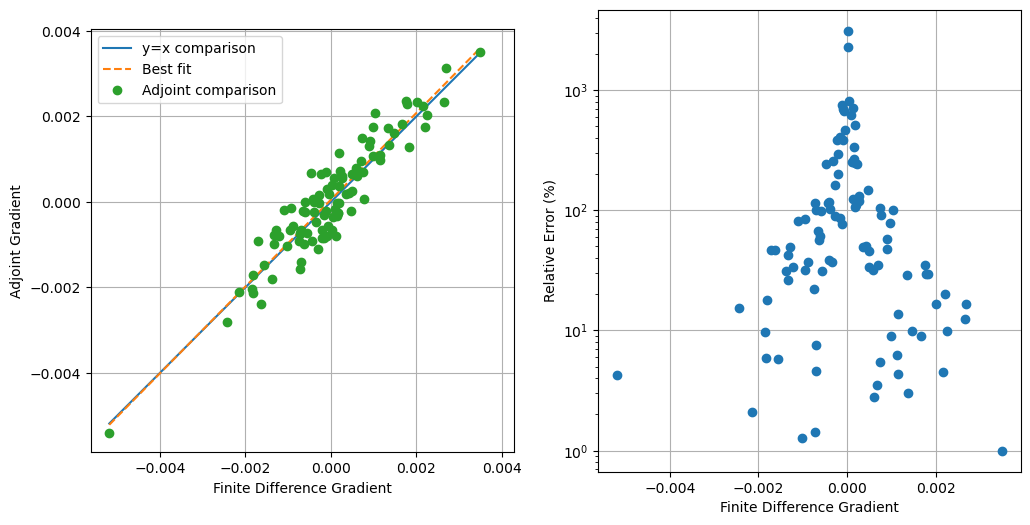

In [65]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / (np.abs(np.squeeze(g_discrete)**2))
    * 100*(np.abs(np.squeeze(g_discrete)))
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

In [41]:
rmse = (np.sqrt(((np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))**2).mean()))

In [32]:
print(rmse)

0.0004751827519275159


In [35]:
print(np.sum(rel_err))

17835.57211611343
